In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_loader import data_load_and_split
from data_loader import data_merge

/Users/ellapalacios/Downloads/tree_proj/data_loader.py:5: DtypeWarning: Columns (86,168,207,211,215) have mixed types. Specify dtype option on import or set low_memory=False.
  def data_load_and_split(big_data=pd.read_csv('/Users/ellapalacios/Downloads/tree_proj/data/final_big_data.csv'),
/Users/ellapalacios/Downloads/tree_proj/data_loader.py:6: DtypeWarning: Columns (55,59,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trimmed_data= pd.read_csv('/Users/ellapalacios/Downloads/tree_proj/data/trimmed_data.csv'),


In [3]:
big_firstMeas_train, big_secondMeas_train, big_firstMeas_test, big_secondMeas_test, trimmed_firstMeas_train, trimmed_secondMeas_train, trimmed_firstMeas_test, trimmed_secondMeas_test = data_load_and_split()
tree_data = data_merge(trimmed_firstMeas_train, trimmed_secondMeas_train, return_mini=False, show_counts_after_burn = False)
tree_data_test = data_merge(trimmed_firstMeas_test, trimmed_secondMeas_test, return_mini=False, show_counts_after_burn= False)


SPCD inconsistent; column will not be merged.
SPGRPCD inconsistent; column will not be merged.
SPCD inconsistent; column will not be merged.
SPGRPCD inconsistent; column will not be merged.


In [4]:
tree_data.CR_pre_burn.value_counts #investigating this since Crown ratio of > 60% is  best -- let's try this as a health indicator. 

<bound method IndexOpsMixin.value_counts of 0       65.0
1       20.0
2       35.0
3       90.0
4       22.0
        ... 
9720    42.0
9721    35.0
9722    55.0
9723    15.0
9724    35.0
Name: CR_pre_burn, Length: 7443, dtype: float64>

(array([ 310.,  750., 1044., 1413.,  771.,  929.,  907.,  658.,  431.,
         230.]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <BarContainer object of 10 artists>)

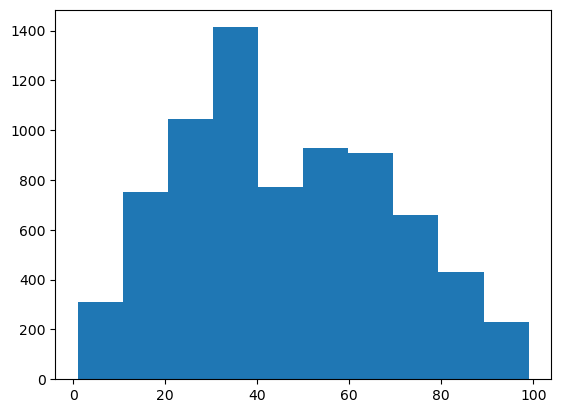

In [5]:
plt.hist(tree_data.CR_pre_burn)

Building a health indicator on Crown Ratio pre and post burn. We consider a tree with 30% or less CR (30.0 or less in the dataset) to be an "unhealthy tree", then between 31 - 59% a 'struggling tree', & 60% or greater a healthy tree.  This will then also be factored in to consider the DBH based on hard versus soft wood to determine overall health. Starting small with just CR as an inidicator and going from there. 

In [6]:
tree_health_CR_ranges = [(tree_data['CR_pre_burn'] <= 30.0), 
                             (tree_data['CR_pre_burn'] > 30.0) & (tree_data['CR_pre_burn'] < 60.0),
                             (tree_data['CR_pre_burn'] >= 60.0)]
tree_health_CR_conditions = ['unhealthy', 'struggling', 'healthy']

tree_data["TREECOND_pre_burn"] = np.select(tree_health_CR_ranges, tree_health_CR_conditions)

#running this for post burn too as a classififer:
tree_health_CR_post_ranges = [pd.isnull(tree_data['CR_post_burn']),
                              (tree_data['CR_post_burn'] <= 30.0),
                              (tree_data['CR_post_burn'] > 30.0) & (tree_data['CR_post_burn'] < 60.0),
                              (tree_data['CR_post_burn'] >= 60.0)]
tree_health_CR_post_conditions = ['dead','unhealthy', 'struggling', 'healthy']
tree_data['TREECOND_post_burn'] = np.select(tree_health_CR_post_ranges, tree_health_CR_post_conditions)

In [7]:
print(tree_data.TREECOND_pre_burn.value_counts(normalize=True))
print()
print(tree_data.ALIVE_pre_burn.value_counts(normalize = True)) #all trees are alive pre-burn, this makes sense

TREECOND_pre_burn
struggling    0.418245
healthy       0.299073
unhealthy     0.282682
Name: proportion, dtype: float64

ALIVE_pre_burn
1    1.0
Name: proportion, dtype: float64


In [8]:
print(tree_data.TREECOND_post_burn.value_counts(normalize = True))
print()
print(tree_data.ALIVE_post_burn.value_counts(normalize = True)) # 0 => dead, so this is saying 72% of sampled trees died. So we really just want to look at which are still alice for their condition. 

TREECOND_post_burn
dead          0.722424
struggling    0.122800
healthy       0.083165
unhealthy     0.071611
Name: proportion, dtype: float64

ALIVE_post_burn
0    0.722424
1    0.277576
Name: proportion, dtype: float64


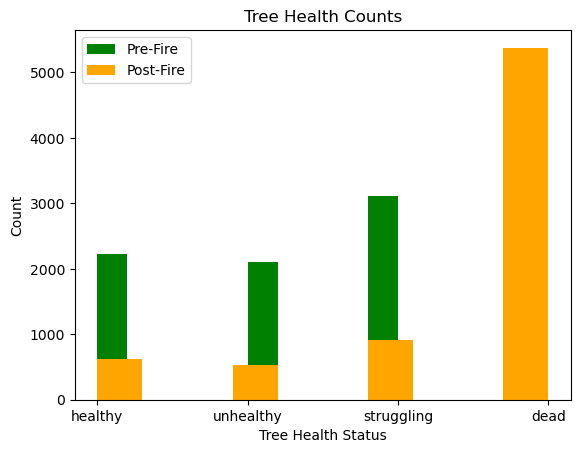

In [9]:
plt.hist(tree_data['TREECOND_pre_burn'], align='mid', color='green', label = 'Pre-Fire')
plt.hist(tree_data['TREECOND_post_burn'], color = 'orange', label = 'Post-Fire')
plt.xlabel('Tree Health Status')
plt.ylabel('Count')
plt.title('Tree Health Counts')
plt.legend()
plt.show()

I think there is something worth working with here with the CR for predicting health but we have to factor in the alive and dead trees after fire.. which I'm not quite sure how to do.  
Lets first consider only the trees that survived the first and use a classifer on those to predict the health after fire.


In [10]:
tree_data_no_dead = tree_data.drop(tree_data[tree_data['TREECOND_post_burn'] == 'dead'].index) #running this dropped us to a total of 2066 trees in the whole set (training data)

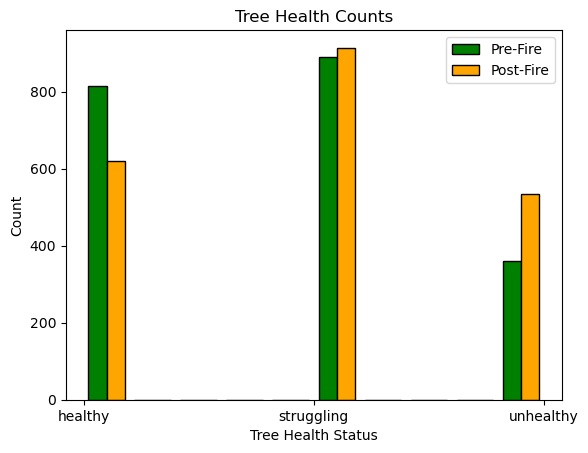

In [11]:
plt.hist([tree_data_no_dead['TREECOND_pre_burn'],tree_data_no_dead['TREECOND_post_burn']], align='mid', color=['green','orange'], label = ['Pre-Fire', 'Post-Fire'], 
         edgecolor = 'black', histtype='bar')
plt.xlabel('Tree Health Status')
plt.ylabel('Count')
plt.title('Tree Health Counts')
plt.legend()
plt.show()

In [12]:
tree_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 7443 entries, 0 to 9724
Data columns (total 104 columns):
 #    Column                             Non-Null Count  Dtype  
---   ------                             --------------  -----  
 0    PLOT                               7443 non-null   int64  
 1    LAT                                7443 non-null   float64
 2    LON                                7443 non-null   float64
 3    ELEV                               7443 non-null   float64
 4    COUNTYCD                           7443 non-null   int64  
 5    UNITCD                             7443 non-null   int64  
 6    PLT_CN_pre_burn                    7443 non-null   int64  
 7    CN                                 7443 non-null   int64  
 8    UNIQUE_PLOT_ID                     7443 non-null   object 
 9    INVYR_pre_burn                     7443 non-null   int64  
 10   MEASYEAR_pre_burn                  7443 non-null   int64  
 11   MEASMON_pre_burn                   7443 non-nu

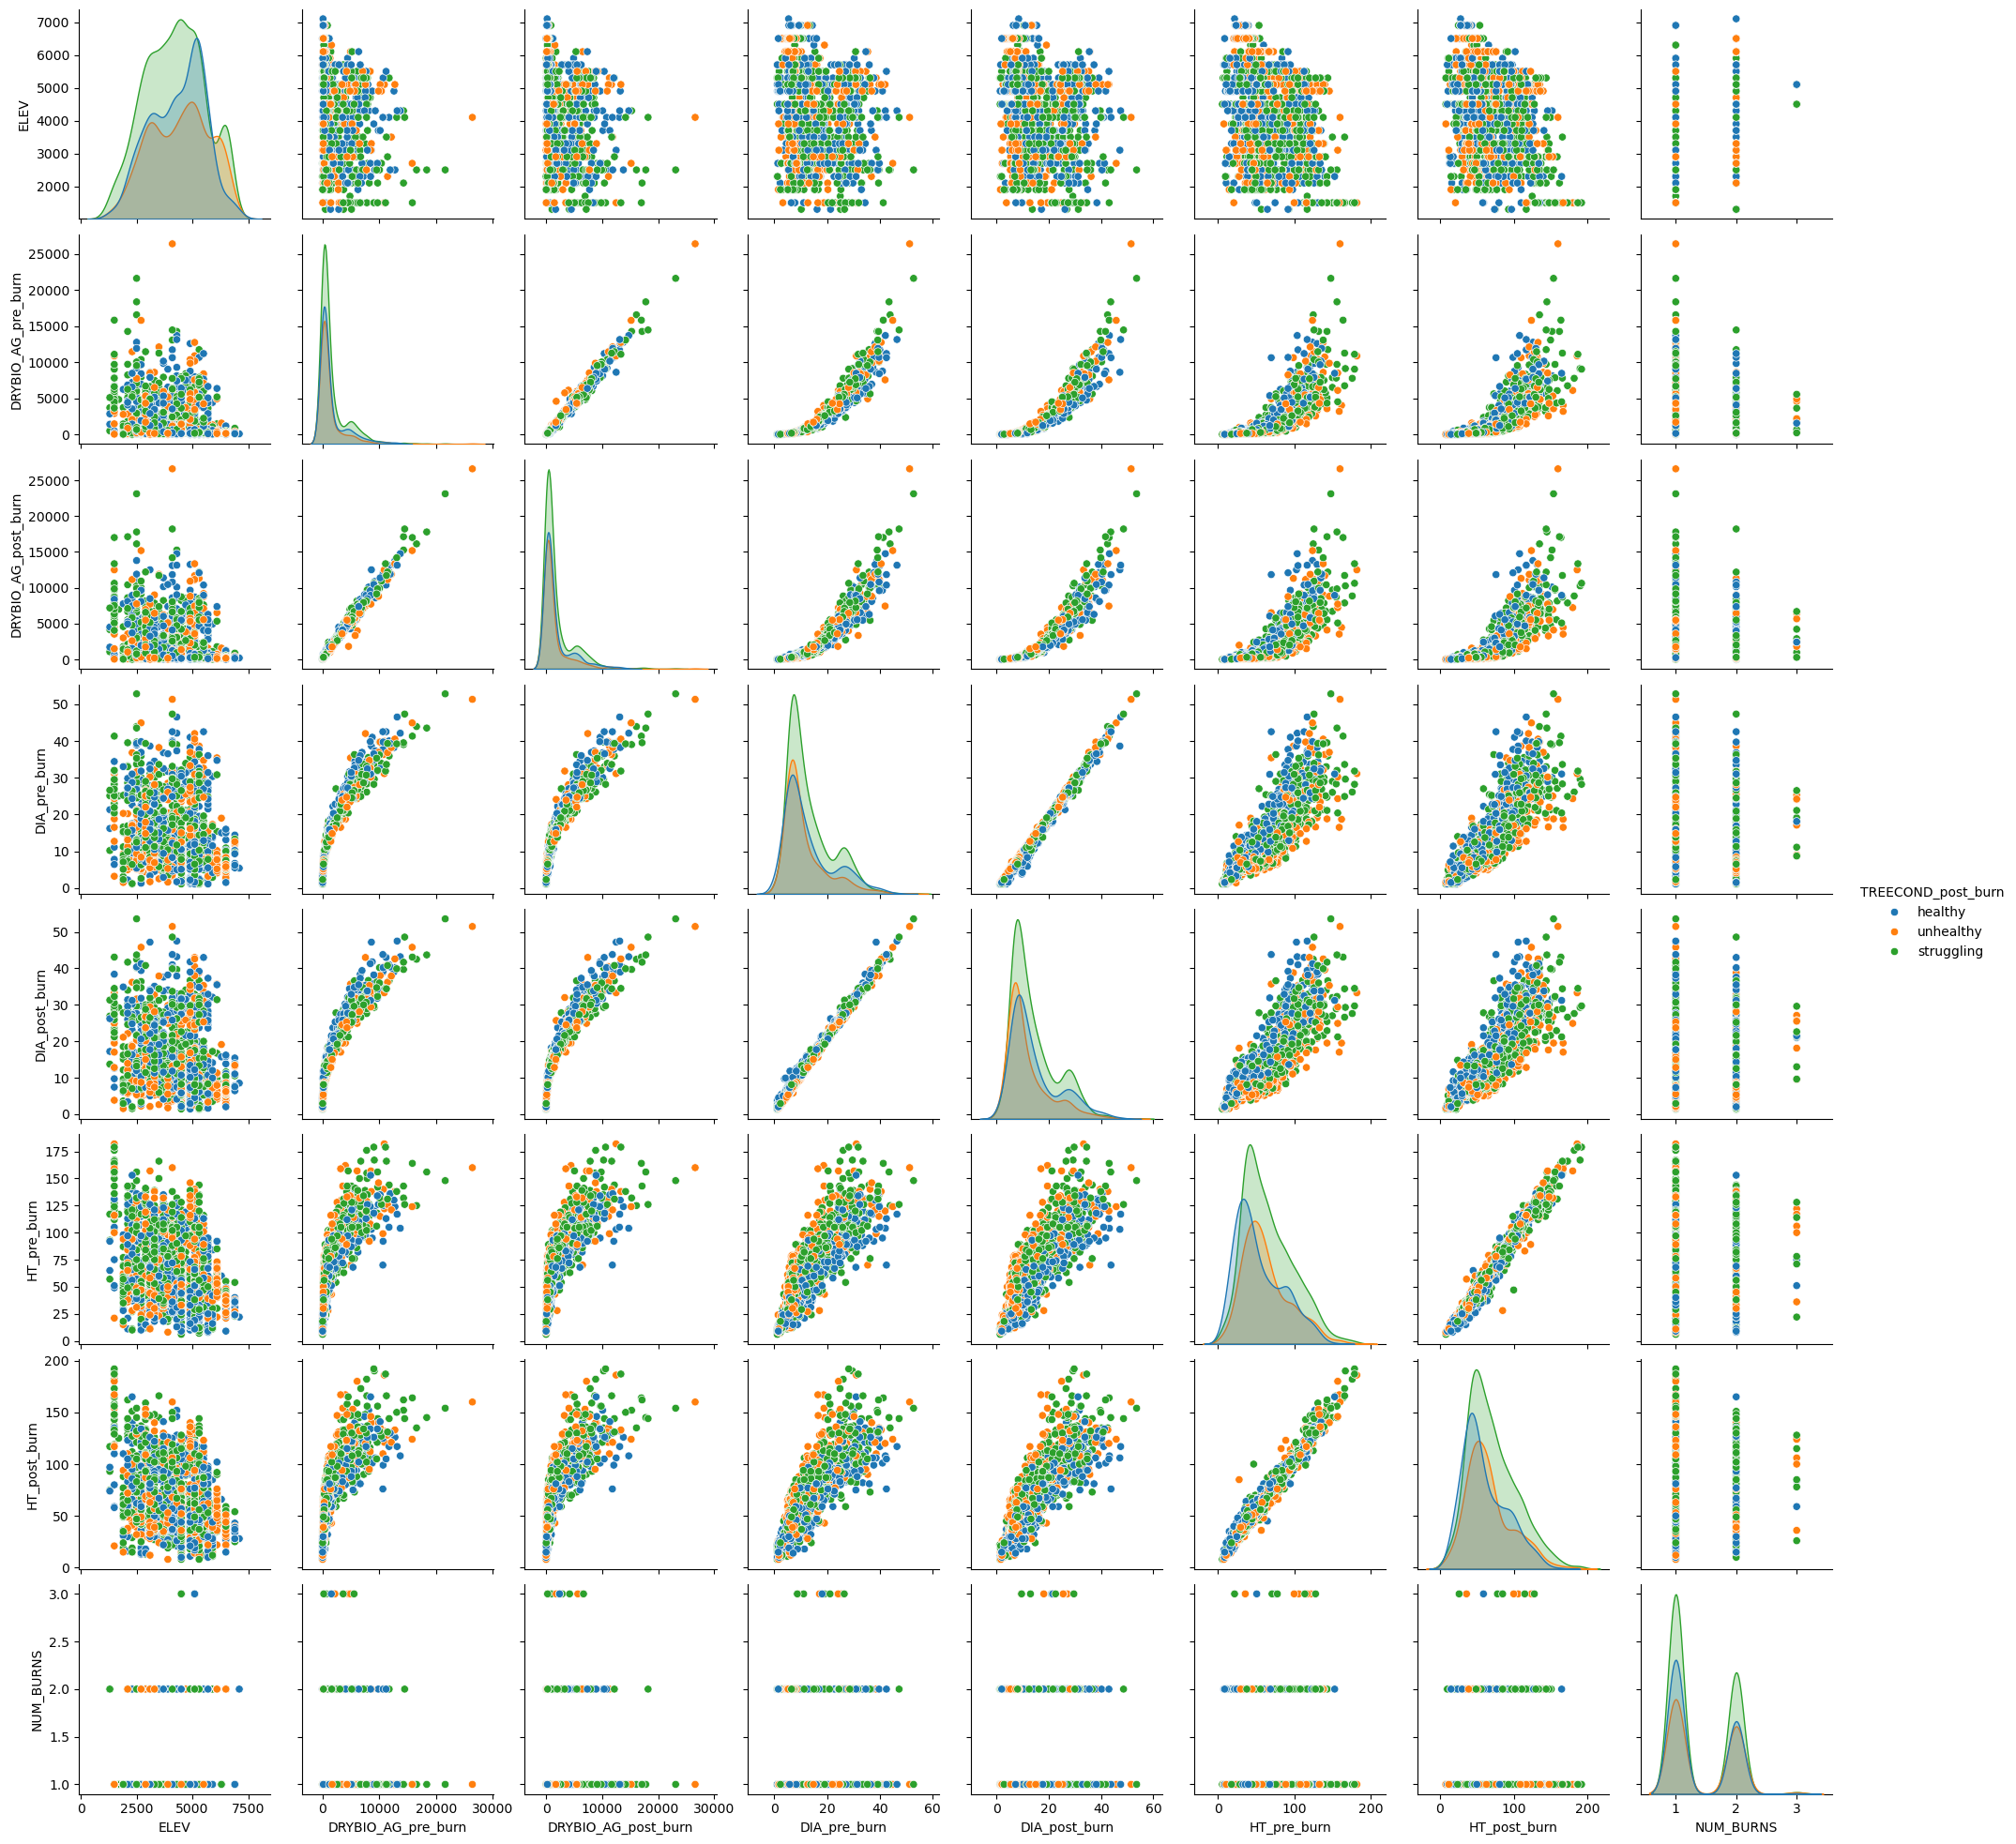

In [13]:
sns.pairplot(tree_data_no_dead[['ELEV','TREECOND_pre_burn', 'TREECOND_post_burn','DRYBIO_AG_pre_burn', 'DRYBIO_AG_post_burn', 'DIA_pre_burn', 'DIA_post_burn',
                                'HT_pre_burn', 'HT_post_burn', 'NUM_BURNS']], hue ='TREECOND_post_burn' )

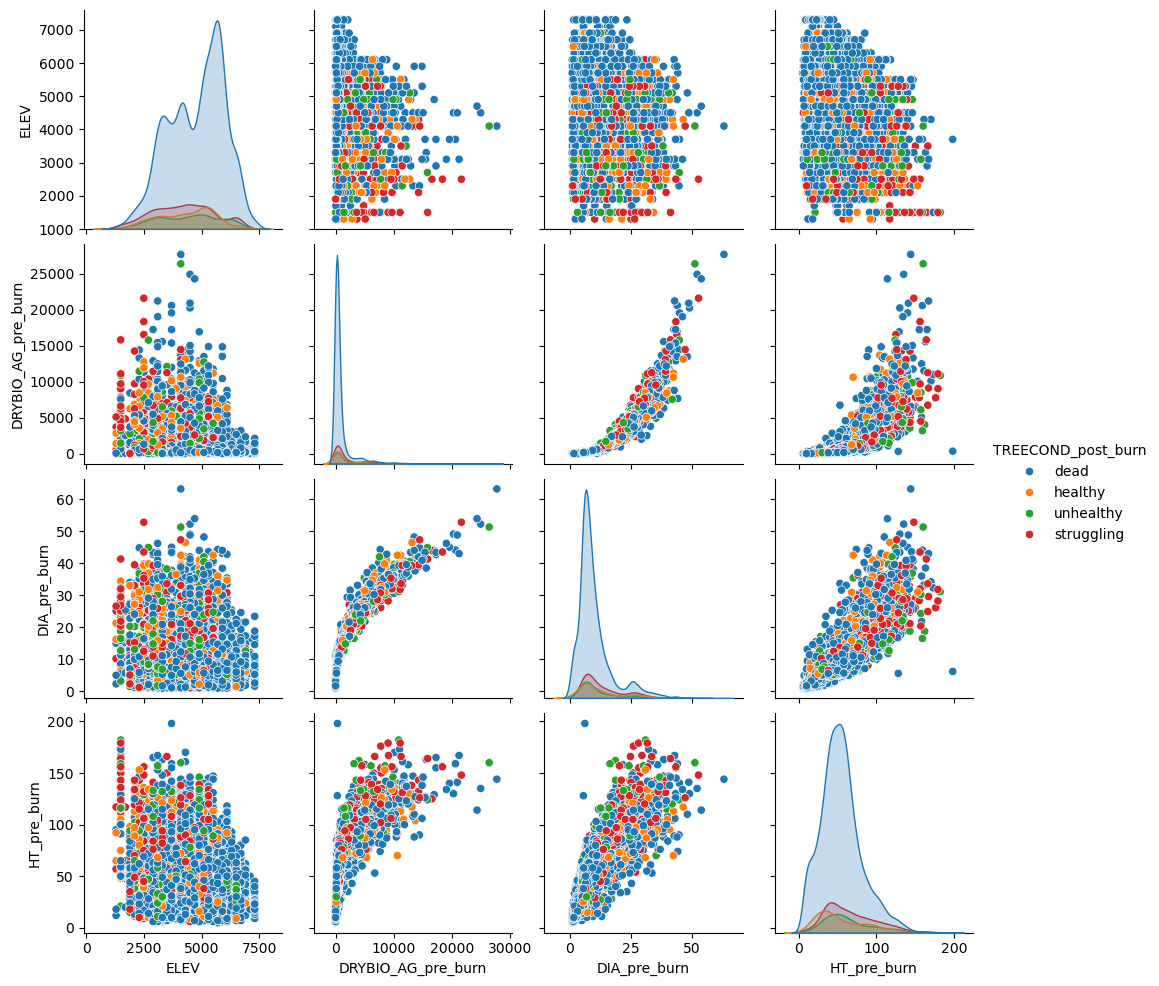

In [14]:
#this plot includes the dead trees, which actually present some interesting results. 

sns.pairplot(tree_data[['ELEV','TREECOND_pre_burn', 'TREECOND_post_burn','DRYBIO_AG_pre_burn', 'DIA_pre_burn', 'HT_pre_burn']], hue ='TREECOND_post_burn' )

Honestly, I'm going to try predicting tree quality health, my TREE_COND_post_fire using all these indicators and seeing what happens for both. I'm quite curious. 

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import top_k_accuracy_score #another form of accuracy score testing (has not been used thus far)
from sklearn.decomposition import PCA #we'll try without PCA first and then with PCA in a future attempt to look at timining and accuracy. 


In [16]:
label_maker = LabelEncoder()
class_mapping = {'dead': 0, 'unhealthy': 1, 'struggling': 2, 'healthy': 3} 
        # ^^ this is so that everything gets encoded the same to both datasets.
tree_data['TREECOND_pre_burn_encoded'] = tree_data['TREECOND_pre_burn'].map(class_mapping)  
tree_data['TREECOND_post_burn_encoded'] = tree_data['TREECOND_post_burn'].map(class_mapping)

tree_data_no_dead['TREECOND_pre_burn_encoded'] = tree_data_no_dead['TREECOND_pre_burn'].map(class_mapping)
tree_data_no_dead['TREECOND_post_burn_encoded'] = tree_data_no_dead['TREECOND_post_burn'].map(class_mapping)



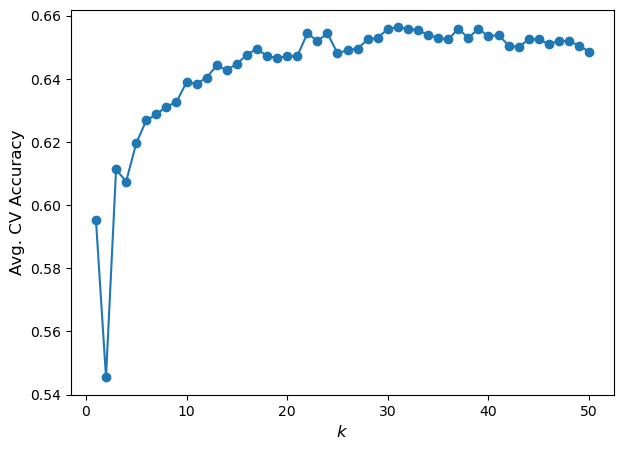

The optimal value of k was 31 which achieved a mean CV accuracy of  0.6563369243546104


In [17]:
num_neighibors = range(1,51)
features = ['ELEV','TREECOND_pre_burn_encoded','DRYBIO_AG_pre_burn', 'DRYBIO_AG_post_burn', 'DIA_pre_burn', 'DIA_post_burn',
            'HT_pre_burn', 'HT_post_burn']
num_splits = 5
num_k_acc = np.zeros((num_splits, len(num_neighibors)))
kfold = StratifiedKFold(n_splits=num_splits, random_state=216, shuffle = True)

i=0
for train_index, test_index in kfold.split(tree_data_no_dead, tree_data_no_dead.TREECOND_post_burn_encoded):
    tree_data_tt = tree_data_no_dead.iloc[train_index]
    tree_data_val = tree_data_no_dead.iloc[test_index]

    j = 0
    for k in num_neighibors:
        knn = Pipeline([('scale', StandardScaler()),('knn classifier', KNeighborsClassifier(k))])
        knn.fit(tree_data_tt[features], tree_data_tt['TREECOND_post_burn_encoded'])
        pred = knn.predict(tree_data_val[features])

        num_k_acc[i,j] = accuracy_score(tree_data_val['TREECOND_post_burn_encoded'], pred)
        j=j+1
    i = i+1

#timiing: 2.3 sec (approx)

#plotting
plt.figure(figsize=(7,5))
plt.plot(num_neighibors, np.mean(num_k_acc, axis=0),'-o')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)
plt.show()

best_k = np.argmax(np.mean(num_k_acc, axis=0))
best_k_acc = np.mean(num_k_acc, axis=0)[best_k]

print("The optimal value of k was", best_k + 1, "which achieved a mean CV accuracy of ", best_k_acc)

In [18]:
#doing KNN on the same data but using all features that are full -- KNN does not handle NA's well. 
tree_data_no_dead_full = tree_data_no_dead.dropna(axis=1, how = 'any')
tree_data_no_dead_full = tree_data_no_dead_full.drop(columns = tree_data_no_dead_full.select_dtypes(include = ['object']).columns) #knn also doesn't like object data types -- dropping off the object data types shouldn't be an issue. 

### Accuracy higher here, but feature map includes regressing on the feature we're trying to predict. 

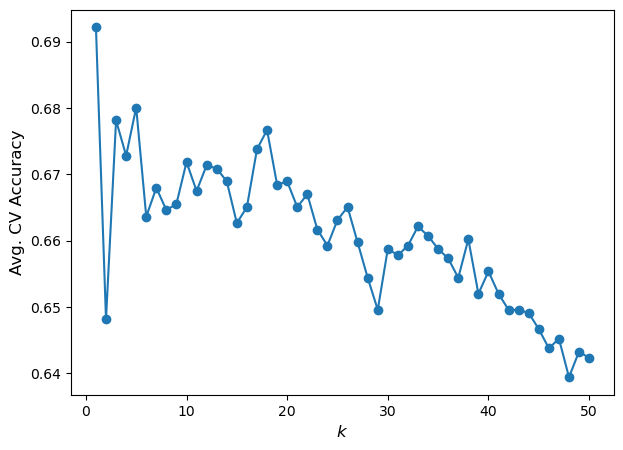

The optimal value of k was 1 which achieved a mean CV accuracy of  0.6921652571615725


In [19]:
num_neighibors = range(1,51)
all_features = tree_data_no_dead_full.columns[:-1] #these features are over fitting, since CR_pre_burn & TREECOND_pre_burn represent the same data 
num_splits = 5
num_k_acc_all = np.zeros((num_splits, len(num_neighibors)))
kfold = StratifiedKFold(n_splits=num_splits, random_state=216, shuffle = True)

i=0
for train_index, test_index in kfold.split(tree_data_no_dead_full, tree_data_no_dead_full.TREECOND_post_burn_encoded):
    tree_data_tt = tree_data_no_dead_full.iloc[train_index]
    tree_data_val = tree_data_no_dead_full.iloc[test_index]

    j = 0
    for k in num_neighibors:
        knn = Pipeline([('scale', StandardScaler()),('knn classifier', KNeighborsClassifier(k))])
        knn.fit(tree_data_tt[all_features], tree_data_tt['TREECOND_post_burn_encoded'])
        pred = knn.predict(tree_data_val[all_features])

        num_k_acc_all[i,j] = accuracy_score(tree_data_val['TREECOND_post_burn_encoded'], pred)
        j=j+1
    i = i+1

#run time is about twice what the previous one took (4.6 sec)

plt.figure(figsize=(7,5))
plt.plot(num_neighibors, np.mean(num_k_acc_all, axis=0),'-o')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

best_k = np.argmax(np.mean(num_k_acc_all, axis=0))
best_k_acc = np.mean(num_k_acc_all, axis=0)[best_k]

print("The optimal value of k was", best_k + 1, "which achieved a mean CV accuracy of ", best_k_acc)

In [20]:
refined_features = ['ELEV', 'CONDID_pre_burn','STATUSCD_pre_burn', 'SPCD_pre_burn', 'SPGRPCD_pre_burn',
                    'DIA_pre_burn', 'HT_pre_burn', 'DRYBIO_AG_pre_burn','CCLCD_pre_burn', 'CONDID_post_burn', 'STATUSCD_post_burn', 'SPCD_post_burn',
                    'SPGRPCD_post_burn', 'DIA_post_burn', 'HT_post_burn','DRYBIO_AG_post_burn', 'CCLCD_post_burn', 'SOFTWOOD', 
                    'HARDWOOD', 'TREECOND_pre_burn_encoded']
#removing futures that could affect learning such as identifcation numbers etc 

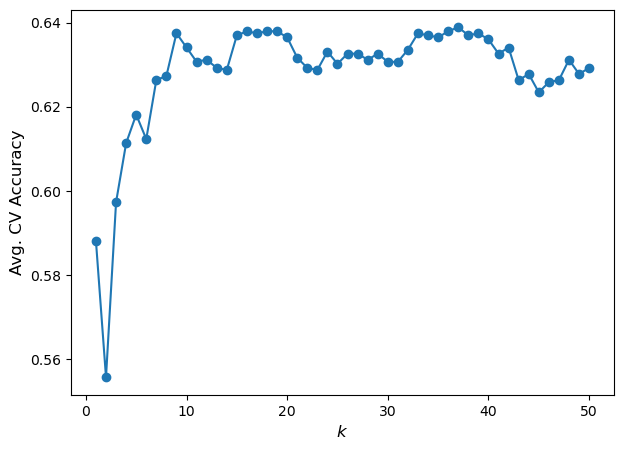

The optimal value of k was 37 which achieved a mean CV accuracy of  0.63890701945234


In [21]:
num_neighibors = range(1,51)
num_splits = 5
num_k_acc_refined = np.zeros((num_splits, len(num_neighibors)))
kfold = StratifiedKFold(n_splits=num_splits, random_state=216, shuffle = True)

i=0
for train_index, test_index in kfold.split(tree_data_no_dead_full, tree_data_no_dead_full.TREECOND_post_burn_encoded):
    tree_data_tt = tree_data_no_dead_full.iloc[train_index]
    tree_data_val = tree_data_no_dead_full.iloc[test_index]

    j = 0
    for k in num_neighibors:
        knn = Pipeline([('scale', StandardScaler()),('knn classifier', KNeighborsClassifier(k))])
        knn.fit(tree_data_tt[refined_features], tree_data_tt['TREECOND_post_burn_encoded'])
        pred = knn.predict(tree_data_val[refined_features])

        num_k_acc_refined[i,j] = accuracy_score(tree_data_val['TREECOND_post_burn_encoded'], pred)
        j=j+1
    i = i+1

#run time is about twice what the previous one took

plt.figure(figsize=(7,5))
plt.plot(num_neighibors, np.mean(num_k_acc_refined, axis=0),'-o')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

best_k = np.argmax(np.mean(num_k_acc_refined, axis=0))
best_k_acc = np.mean(num_k_acc_refined, axis=0)[best_k]

print("The optimal value of k was", best_k + 1, "which achieved a mean CV accuracy of ", best_k_acc)

#runtime approx 4.2 sec

From here there are a few options, continue with a PCA analysis to determine an optimal number of features, but that has been explored in the previous KNN to some extent. Our other option is to use the full tree set where we would also be considering dead trees in the model for prediction. This results in some complictions since KNN does not handle NaN values well, though returns suggestions for similar models that do handle these values. We can also consider a differnet method of classification such as a random forest or decsion tree classifer, which Henry is currently working on. Finally, we can also re-construct our method for determining how healthy trees are using the height, crown and DBA.  
I'll begin by adding a small PCA to the best working model for explorations purpose and then move onto the whole dataset. 

In [22]:
pca = Pipeline([('scale', StandardScaler()),('pca', PCA(2))])
pca_values = pca.fit_transform(tree_data_no_dead_full[refined_features])


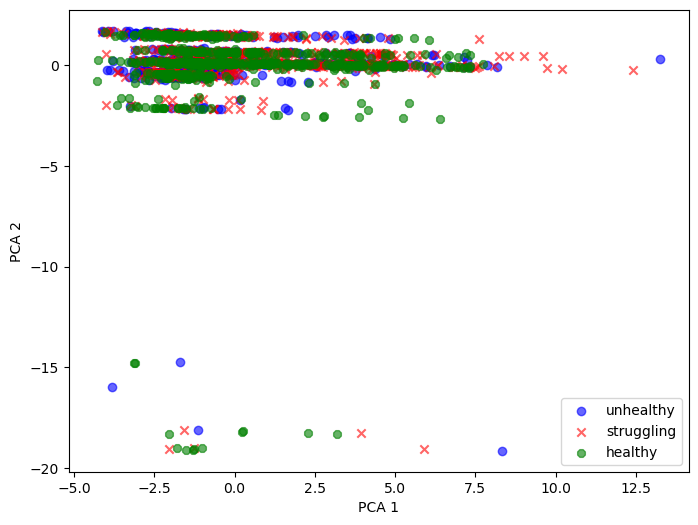

In [23]:
#plotting -- just curious
plt.figure(figsize=(8,6))
plt.scatter(pca_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==1, 0],
            pca_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==1, 1], 
            color = 'blue', alpha = 0.6, label = 'unhealthy')
plt.scatter(pca_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==2, 0],
            pca_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==2, 1], 
            color = 'red',marker='x', alpha = 0.6, label = 'struggling')
plt.scatter(pca_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==3, 0],
            pca_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==3, 1], 
            color = 'green',marker='8', alpha = 0.6, label = 'healthy')
plt.legend()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

This didn't pull things apart a lot, but we can try linear discriminat analysis since a lot of our data is rather linear.

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis() #trying without scaling
lda_values = lda.fit_transform(tree_data_no_dead_full[refined_features], tree_data_no_dead_full.TREECOND_post_burn_encoded)

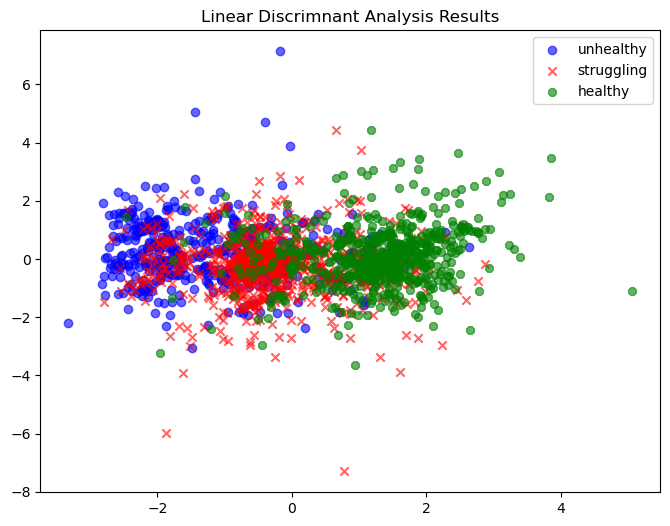

In [25]:
#plotting
plt.figure(figsize=(8,6))
plt.scatter(lda_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==1, 0],
            lda_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==1, 1], 
            color = 'blue', alpha = 0.6, label = 'unhealthy')
plt.scatter(lda_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==2, 0],
            lda_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==2, 1], 
            color = 'red',marker='x', alpha = 0.6, label = 'struggling')
plt.scatter(lda_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==3, 0],
            lda_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==3, 1], 
            color = 'green',marker='8', alpha = 0.6, label = 'healthy')
plt.legend()
plt.title('Linear Discrimnant Analysis Results')
plt.show()

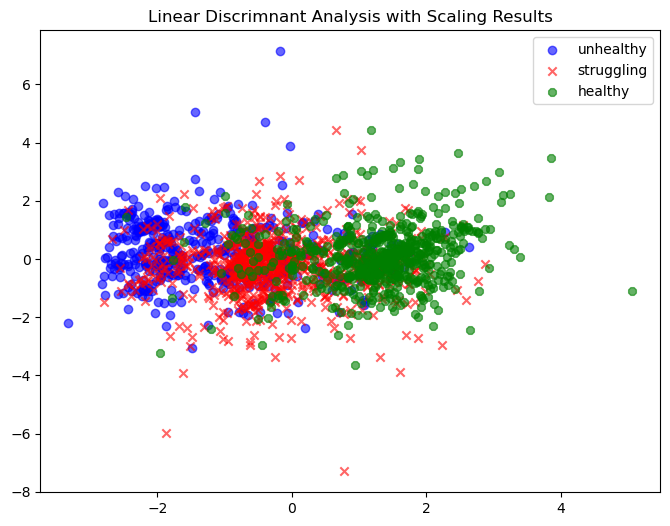

In [26]:
#trying once with scaling... 
lda_2 = Pipeline([('scale', StandardScaler()),('lda', LinearDiscriminantAnalysis())])
lda2_values = lda_2.fit_transform(tree_data_no_dead_full[refined_features], tree_data_no_dead_full.TREECOND_post_burn_encoded)

#plotting
plt.figure(figsize=(8,6))
plt.scatter(lda2_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==1, 0],
            lda2_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==1, 1], 
            color = 'blue', alpha = 0.6, label = 'unhealthy')
plt.scatter(lda2_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==2, 0],
            lda2_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==2, 1], 
            color = 'red',marker='x', alpha = 0.6, label = 'struggling')
plt.scatter(lda2_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==3, 0],
            lda2_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==3, 1], 
            color = 'green',marker='8', alpha = 0.6, label = 'healthy')
plt.legend()
plt.title('Linear Discrimnant Analysis with Scaling Results')
plt.show()

These are nearly identical results, and LDA does do some scaling automatically, let's run with a KNN on this data. In the pipeline there will be LDA and then a KNN step. 

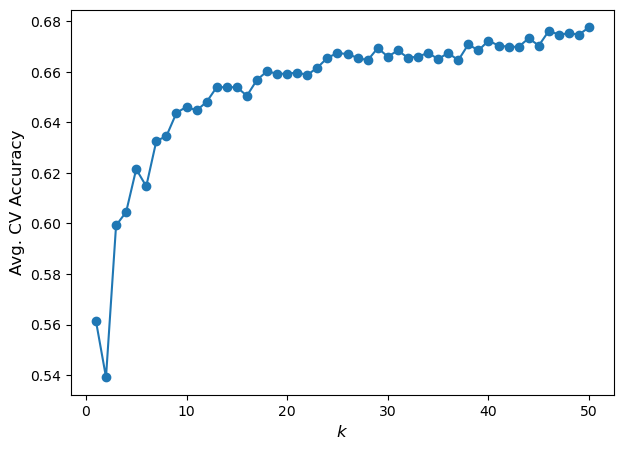

The optimal value of k was 50 which achieved a mean CV accuracy of  0.6776327332701687


In [27]:
#KNN w LDA
num_neighibors = range(1,51)
num_splits = 5
num_k_acc_refined = np.zeros((num_splits, len(num_neighibors)))
kfold = StratifiedKFold(n_splits=num_splits, random_state=216, shuffle = True)

i=0
for train_index, test_index in kfold.split(tree_data_no_dead_full, tree_data_no_dead_full.TREECOND_post_burn_encoded):
    tree_data_tt = tree_data_no_dead_full.iloc[train_index]
    tree_data_val = tree_data_no_dead_full.iloc[test_index]

    j = 0
    for k in num_neighibors:
        knn = Pipeline([('lda', LinearDiscriminantAnalysis()),('knn classifier', KNeighborsClassifier(k))])
        knn.fit(tree_data_tt[refined_features], tree_data_tt['TREECOND_post_burn_encoded'])
        pred = knn.predict(tree_data_val[refined_features])

        num_k_acc_refined[i,j] = accuracy_score(tree_data_val['TREECOND_post_burn_encoded'], pred)
        j=j+1
    i = i+1

#run time: 8.9 seconds

plt.figure(figsize=(7,5))
plt.plot(num_neighibors, np.mean(num_k_acc_refined, axis=0),'-o')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

best_k = np.argmax(np.mean(num_k_acc_refined, axis=0))
best_k_acc = np.mean(num_k_acc_refined, axis=0)[best_k]

print("The optimal value of k was", best_k + 1, "which achieved a mean CV accuracy of ", best_k_acc) #removing 'NUM_FIRES' from refined features resulted in needing more neihbors for the same accuracy and more varied accuracy scores. 



This performs incredibly well. Tomorrow we'll test on some test data and find a way of including our dead trees. That said... this does model what happens to trees before and after a fire.. 

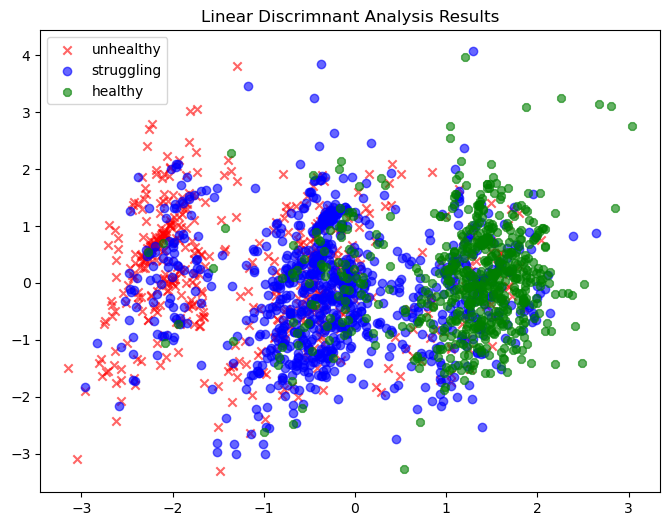

In [28]:
#considering only pre-fire features
pre_fire_features = ['ELEV', 'STATUSCD_pre_burn', 'SPCD_pre_burn', 'SPGRPCD_pre_burn',
                    'DIA_pre_burn', 'HT_pre_burn', 'DRYBIO_AG_pre_burn','CCLCD_pre_burn', 'HARDWOOD', 'SOFTWOOD', 'TREECOND_pre_burn_encoded', 'YRS_SINCE_BURN' ] 
lda_pre_fire = LinearDiscriminantAnalysis() 
lda_values = lda_pre_fire.fit_transform(tree_data_no_dead_full[pre_fire_features], tree_data_no_dead_full.TREECOND_post_burn_encoded)

#plotting
plt.figure(figsize=(8,6))

plt.scatter(lda_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==1, 0],
            lda_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==1, 1], 
            color = 'red',marker = 'x', alpha = 0.6, label = 'unhealthy')
plt.scatter(lda_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==2, 0],
            lda_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==2, 1], 
            color = 'blue', alpha = 0.6, label = 'struggling')
plt.scatter(lda_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==3, 0],
            lda_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==3, 1], 
            color = 'green',marker='8', alpha = 0.6, label = 'healthy')
plt.legend()
plt.title('Linear Discrimnant Analysis Results')
plt.show()

#less good, but still not bad


In [40]:
#dummy classifier for sanity check 
from sklearn.dummy import DummyClassifier, DummyRegressor



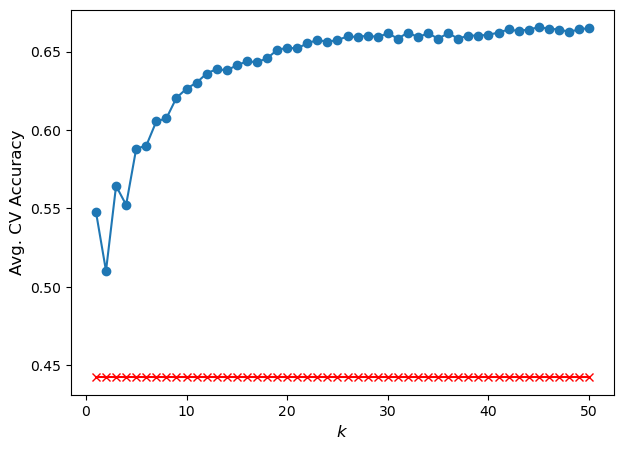

The optimal value of k was 45 which achieved a mean CV accuracy of  0.6655402323051549
The optimal value of k for the dummy classifier was  1.4424009544864371 which achieved a Cross Validation accuracy of 0.44240095448643724


In [44]:
#KNN w LDA
num_neighibors = range(1,51)
num_splits = 5
num_k_acc_pre_fire = np.zeros((num_splits, len(num_neighibors)))
num_k_dummy = np.zeros((num_splits, len(num_neighibors)))
kfold = StratifiedKFold(n_splits=num_splits, random_state=216, shuffle = True)

i=0
for train_index, test_index in kfold.split(tree_data_no_dead_full, tree_data_no_dead_full.TREECOND_post_burn_encoded):
    tree_data_tt = tree_data_no_dead_full.iloc[train_index]
    tree_data_val = tree_data_no_dead_full.iloc[test_index]

    j = 0
    for k in num_neighibors:
        knn = Pipeline([('lda', LinearDiscriminantAnalysis()),('knn classifier', KNeighborsClassifier(k))])
        knn.fit(tree_data_tt[pre_fire_features], tree_data_tt['TREECOND_post_burn_encoded'])
        pred = knn.predict(tree_data_val[pre_fire_features])

        dummy = DummyClassifier()
        dummy.fit(tree_data_tt[pre_fire_features], tree_data_tt['TREECOND_post_burn_encoded'])
        dummy_pred = dummy.predict(tree_data_val[pre_fire_features])

        num_k_dummy[i, j] = accuracy_score(tree_data_val['TREECOND_post_burn_encoded'], dummy_pred)
        num_k_acc_pre_fire[i,j] = accuracy_score(tree_data_val['TREECOND_post_burn_encoded'], pred)
        j=j+1
    i = i+1

#run time: 2.3 seconds

plt.figure(figsize=(7,5))
plt.plot(num_neighibors, np.mean(num_k_acc_pre_fire, axis=0),'-o')
plt.plot(num_neighibors, np.mean(num_k_dummy, axis = 0), color = 'red', marker = 'x')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

best_k = np.argmax(np.mean(num_k_acc_pre_fire, axis=0))
best_k_acc = np.mean(num_k_acc_pre_fire, axis=0)[best_k]

best_k_dummy = np.argmax(np.mean(num_k_dummy, axis = 0))
best_k_dummy_acc = np.mean(num_k_dummy, axis = 0)[best_k_dummy]

print("The optimal value of k was", best_k + 1, "which achieved a mean CV accuracy of ", best_k_acc)
print("The optimal value of k for the dummy classifier was ", best_k_dummy_acc +1, 'which achieved a Cross Validation accuracy of', best_k_dummy_acc)

#with .TREECOND_post_burn_endcoded --> k = 49, accuracy = 65%
#with ['featre'] --> k = 49, accuracy = 65% so this likely doesn't make a difference
#with pre_burn_encoded removed --> k = 46, accuracy 54% .. makes things worse, logcially 
#with SOFTWOOD removed --> k = 49, accuracy 65% (not much of a difference given it's  a binary feature)
#remove CONDID_pre-burn since it's a plotwise metric --> k = 45, accruacy 66.5%
#added NUM_BURNS -- let's just see.. I'm a little curious k = 47, accuracy 66.4% (why did that not change a lot, it certinaly affected the LDA.. )
#without NUM_BURNS --> k = 45, 66.5% accuracy score. 
#added YRS_SINCE_BURN --> k = 45, accuracy  =  66.5% identical 


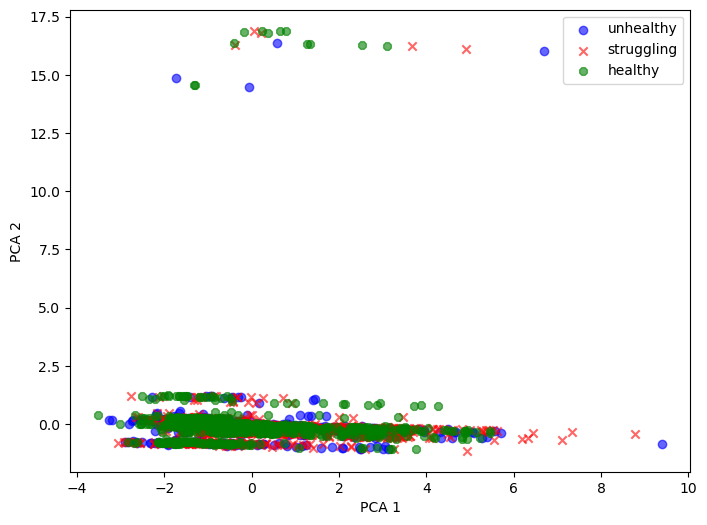

In [30]:
#trying PCA just to see
pca = Pipeline([('scale', StandardScaler()),('pca', PCA(2))]) 
pca_values = pca.fit_transform(tree_data_no_dead_full[pre_fire_features])

#plotting -- just curious
plt.figure(figsize=(8,6))
plt.scatter(pca_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==1, 0],
            pca_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==1, 1], 
            color = 'blue', alpha = 0.6, label = 'unhealthy')
plt.scatter(pca_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==2, 0],
            pca_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==2, 1], 
            color = 'red',marker='x', alpha = 0.6, label = 'struggling')
plt.scatter(pca_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==3, 0],
            pca_values[tree_data_no_dead_full.TREECOND_post_burn_encoded==3, 1], 
            color = 'green',marker='8', alpha = 0.6, label = 'healthy')
plt.legend()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()
#very different still a mess 

### This one is halfway decent -- but I'm not sure it's 100% what we're looking for since it includes both pre and post burn data. 

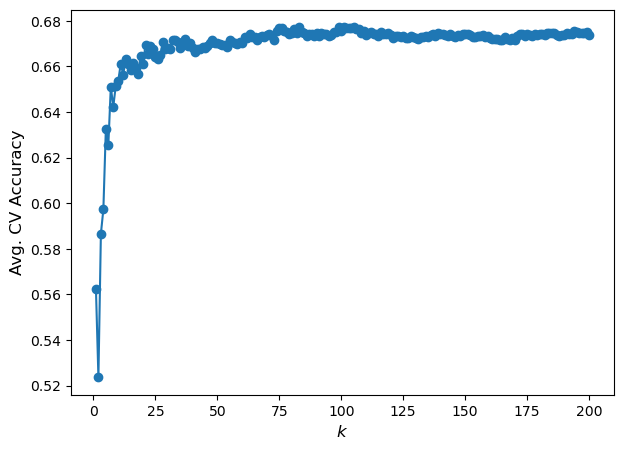

The optimal value of k was 99 which achieved a mean CV accuracy of  0.6771531506240422


In [31]:
only_tree_features = ['ELEV', 'SPCD_pre_burn', 'SPGRPCD_pre_burn','DIA_pre_burn', 'HT_pre_burn', 'DRYBIO_AG_pre_burn','CCLCD_pre_burn',
                      'SPCD_post_burn','SPGRPCD_post_burn', 'DIA_post_burn', 'HT_post_burn','DRYBIO_AG_post_burn', 'CCLCD_post_burn', 
                      'SOFTWOOD', 'HARDWOOD', 'NUM_BURNS', 'TREECOND_pre_burn_encoded']

num_neighibors = range(1,201)
num_splits = 5
num_k_acc_only_tree = np.zeros((num_splits, len(num_neighibors)))
kfold = StratifiedKFold(n_splits=num_splits, random_state=216, shuffle = True)

i=0
for train_index, test_index in kfold.split(tree_data_no_dead_full, tree_data_no_dead_full.TREECOND_post_burn_encoded):
    tree_data_tt = tree_data_no_dead_full.iloc[train_index]
    tree_data_val = tree_data_no_dead_full.iloc[test_index]

    j = 0
    for k in num_neighibors:
        knn = Pipeline([('lda', LinearDiscriminantAnalysis()),('knn classifier', KNeighborsClassifier(k))])
        knn.fit(tree_data_tt[only_tree_features], tree_data_tt['TREECOND_post_burn_encoded'])
        pred = knn.predict(tree_data_val[only_tree_features])

        num_k_acc_only_tree[i,j] = accuracy_score(tree_data_val['TREECOND_post_burn_encoded'], pred)
        j=j+1
    i = i+1

#run time: 2.3 seconds

plt.figure(figsize=(7,5))
plt.plot(num_neighibors, np.mean(num_k_acc_only_tree, axis=0),'-o')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

best_k = np.argmax(np.mean(num_k_acc_only_tree, axis=0))
best_k_acc = np.mean(num_k_acc_only_tree, axis=0)[best_k]

print("The optimal value of k was", best_k + 1, "which achieved a mean CV accuracy of ", best_k_acc) 

#k = 50 --> accuracy 0.67 
#k = 88 --> Accuracy 0.67 (nearly the same) ---- run time 15.4 seconds
#using tree featues only (no CONDID or STATUS (though that could be argued)) --> k = 100, accuracy = 67.7% (15.4 sec run time)
#same features are the previous --> k = 103, accuracy = 67.9% 
#added num_burns --> k = 99, accuracy = 67.7%


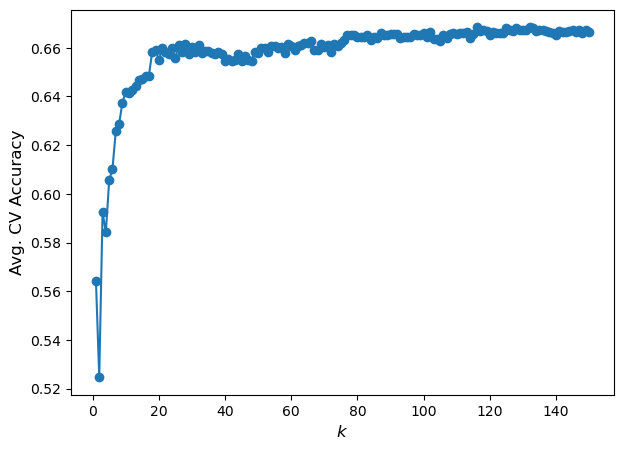

The optimal value of k was 132 which achieved a mean CV accuracy of  0.6684411224573348


In [32]:
#looking as just post burn features, this can help determine which is carrying the LDA. 
post_burn_features = ['ELEV','CONDID_post_burn', 'STATUSCD_post_burn', 'SPCD_post_burn','SPGRPCD_post_burn', 'DIA_post_burn', 'HT_post_burn','DRYBIO_AG_post_burn', 'CCLCD_post_burn', 
                      'SOFTWOOD', 'HARDWOOD', 'NUM_BURNS' ,'TREECOND_pre_burn_encoded'] 

num_neighibors = range(1,151)
num_splits = 5
num_k_acc_post_burn = np.zeros((num_splits, len(num_neighibors)))
kfold = StratifiedKFold(n_splits=num_splits, random_state=216, shuffle = True)

i=0
for train_index, test_index in kfold.split(tree_data_no_dead_full, tree_data_no_dead_full.TREECOND_post_burn_encoded):
    tree_data_tt = tree_data_no_dead_full.iloc[train_index]
    tree_data_val = tree_data_no_dead_full.iloc[test_index]

    j = 0
    for k in num_neighibors:
        knn = Pipeline([('lda', LinearDiscriminantAnalysis()),('knn classifier', KNeighborsClassifier(k))])
        knn.fit(tree_data_tt[post_burn_features], tree_data_tt['TREECOND_post_burn_encoded'])
        pred = knn.predict(tree_data_val[post_burn_features])

        num_k_acc_post_burn[i,j] = accuracy_score(tree_data_val['TREECOND_post_burn_encoded'], pred)
        j=j+1
    i = i+1

#run time: 2.3 seconds

plt.figure(figsize=(7,5))
plt.plot(num_neighibors, np.mean(num_k_acc_post_burn, axis=0),'-o')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

best_k = np.argmax(np.mean(num_k_acc_post_burn, axis=0))
best_k_acc = np.mean(num_k_acc_post_burn, axis=0)[best_k]

print("The optimal value of k was", best_k + 1, "which achieved a mean CV accuracy of ", best_k_acc) 

#k = 99 --> accurary score 66.4% (5.0 seconds run time)
#added NUM_BURNS --> k = 100, accuracy score  = 66.6%
                # --> k = 132, accuracy sccore 66.8%


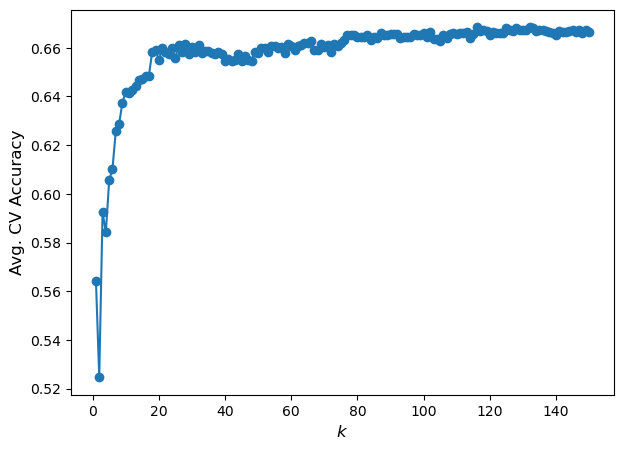

The optimal value of k was 132 which achieved a mean CV accuracy of  0.6684411224573348


In [33]:
num_neighibors = range(1,151)
num_splits = 5
num_k_acc_post_burn = np.zeros((num_splits, len(num_neighibors)))
kfold = StratifiedKFold(n_splits=num_splits, random_state=216, shuffle = True)

i=0
for train_index, test_index in kfold.split(tree_data_no_dead_full, tree_data_no_dead_full.TREECOND_post_burn_encoded):
    tree_data_tt = tree_data_no_dead_full.iloc[train_index]
    tree_data_val = tree_data_no_dead_full.iloc[test_index]

    j = 0
    for k in num_neighibors:
        knn = Pipeline([('lda', LinearDiscriminantAnalysis()),('knn classifier', KNeighborsClassifier(k))])
        knn.fit(tree_data_tt[post_burn_features], tree_data_tt['TREECOND_post_burn_encoded'])
        pred = knn.predict(tree_data_val[post_burn_features])

        num_k_acc_post_burn[i,j] = accuracy_score(tree_data_val['TREECOND_post_burn_encoded'], pred)
        j=j+1
    i = i+1

#run time: 2.3 seconds

plt.figure(figsize=(7,5))
plt.plot(num_neighibors, np.mean(num_k_acc_post_burn, axis=0),'-o')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

best_k = np.argmax(np.mean(num_k_acc_post_burn, axis=0))
best_k_acc = np.mean(num_k_acc_post_burn, axis=0)[best_k]

print("The optimal value of k was", best_k + 1, "which achieved a mean CV accuracy of ", best_k_acc) 

#k = 99 --> accurary score 66% (5.0 seconds run time) (with LDA)
#k = 15 --> accuracy score 50% (4.5 seconds run time) --- PCA(2)
#k = 8 --> accruacy score 51% (4.6 seconds run time ) --- PCA(6)
#k = 8 --> accuracy score 51% (5.6 seconds run time) --- PCA(9) 
        #conclusion: PCA doesn't help us
#k = 125 --> accuracy score 66.4% (8.4 secons run time) --- LDA w up to 150 neighbors 

## On Testing Set: 

In [34]:
#building out the test set to fit this model (aka encoding and dropping off the dead trees)
tree_health_CR_ranges = [(tree_data_test['CR_pre_burn'] <= 30.0), 
                             (tree_data_test['CR_pre_burn'] > 30.0) & (tree_data_test['CR_pre_burn'] < 60.0),
                             (tree_data_test['CR_pre_burn'] >= 60.0)]
tree_health_CR_conditions = ['unhealthy', 'struggling', 'healthy']

tree_data_test["TREECOND_pre_burn"] = np.select(tree_health_CR_ranges, tree_health_CR_conditions)
class_mapping = {'dead': 0, 'unhealthy': 1, 'struggling': 2, 'healthy': 3} 
        # ^^ this is so that everything gets encoded the same to both datasets.
tree_data_test['TREECOND_pre_burn_encoded'] = tree_data_test['TREECOND_pre_burn'].map(class_mapping)  

tree_health_CR_post_ranges = [tree_data_test['CR_post_burn'].isnull(),
                              (tree_data_test['CR_post_burn'] <= 30.0),
                              (tree_data_test['CR_post_burn'] > 30.0) & (tree_data_test['CR_post_burn'] < 60.0),
                              (tree_data_test['CR_post_burn'] >= 60.0)]
tree_health_CR_post_conditions = ['dead','unhealthy', 'struggling', 'healthy']

tree_data_test['TREECOND_post_burn'] = np.select(tree_health_CR_post_ranges, tree_health_CR_post_conditions)


tree_data_test['TREECOND_post_burn_encoded'] = tree_data_test['TREECOND_post_burn'].map(class_mapping)

#dropping off dead trees
tree_data_no_dead_test = tree_data_test.drop(tree_data_test[tree_data_test['TREECOND_post_burn'] == 'dead'].index)
tree_data_no_dead_test['TREECOND_pre_burn_encoded'] = tree_data_no_dead_test['TREECOND_pre_burn'].map(class_mapping)
tree_data_no_dead_test['TREECOND_post_burn_encoded'] = tree_data_no_dead_test['TREECOND_post_burn'].map(class_mapping)

#finally dropping off any features that are objects
tree_data_no_dead_full_test = tree_data_no_dead_test.dropna(axis=1, how = 'any')
tree_data_no_dead_full_test = tree_data_no_dead_full_test.drop(columns = tree_data_no_dead_full_test.select_dtypes(include = ['object']).columns)


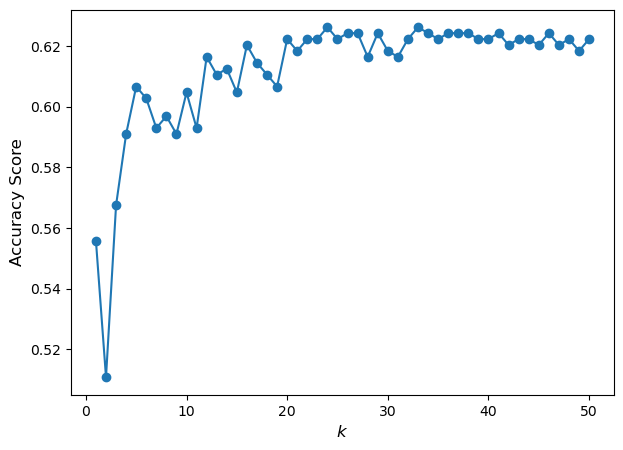

The optimal value of k was 24 which achieved an accuracy of  0.6262230919765166


In [38]:
#applying the previous best performing model and having slim expectations
pre_fire_features = ['ELEV', 'STATUSCD_pre_burn', 'SPCD_pre_burn', 'SPGRPCD_pre_burn',
                    'DIA_pre_burn', 'HT_pre_burn', 'DRYBIO_AG_pre_burn','CCLCD_pre_burn', 'HARDWOOD', 'SOFTWOOD', 'TREECOND_pre_burn_encoded' ] 
#KNN w LDA
num_neighibors = range(1,51)
num_k_acc_pre_fire_test = np.zeros(len(num_neighibors))

i=0
for k in num_neighibors:
    knn = Pipeline([('lda', LinearDiscriminantAnalysis()),('knn classifier', KNeighborsClassifier(k))])
    knn.fit(tree_data_no_dead_full[pre_fire_features], tree_data_no_dead_full['TREECOND_post_burn_encoded'])
    pred = knn.predict(tree_data_no_dead_full_test[pre_fire_features])
    num_k_acc_pre_fire_test[i] = accuracy_score(tree_data_no_dead_full_test['TREECOND_post_burn_encoded'], pred)
    i = i+1

#run time: 2.3 seconds

plt.figure(figsize=(7,5))
plt.plot(num_neighibors, num_k_acc_pre_fire_test,'-o')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)

plt.show()

best_k = np.argmax(num_k_acc_pre_fire_test, axis=0)
best_k_acc = num_k_acc_pre_fire_test[best_k]

print("The optimal value of k was", best_k + 1, "which achieved an accuracy of ", best_k_acc)


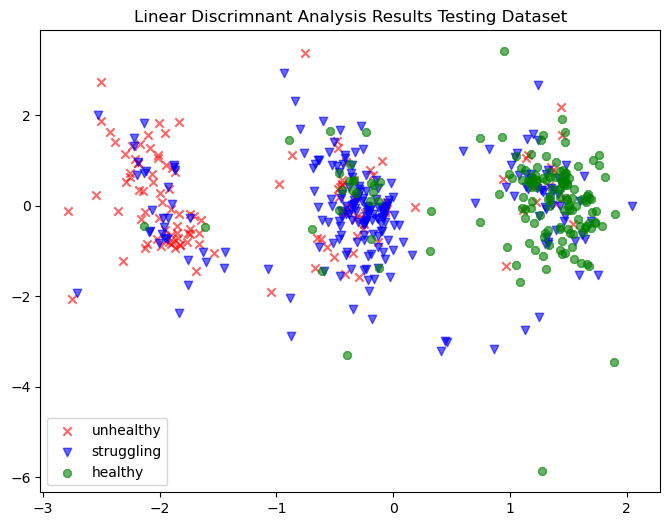

In [36]:
#exploring LDA
lda_pre_fire = LinearDiscriminantAnalysis() 
lda_values = lda_pre_fire.fit_transform(tree_data_no_dead_full_test[pre_fire_features], tree_data_no_dead_full_test.TREECOND_post_burn_encoded)

#plotting
plt.figure(figsize=(8,6))
plt.scatter(lda_values[tree_data_no_dead_full_test.TREECOND_post_burn_encoded==1, 0],
            lda_values[tree_data_no_dead_full_test.TREECOND_post_burn_encoded==1, 1], 
            color = 'red',marker = 'x', alpha = 0.6, label = 'unhealthy')
plt.scatter(lda_values[tree_data_no_dead_full_test.TREECOND_post_burn_encoded==2, 0],
            lda_values[tree_data_no_dead_full_test.TREECOND_post_burn_encoded==2, 1], 
            color = 'blue',marker='v', alpha = 0.6, label = 'struggling')
plt.scatter(lda_values[tree_data_no_dead_full_test.TREECOND_post_burn_encoded==3, 0],
            lda_values[tree_data_no_dead_full_test.TREECOND_post_burn_encoded==3, 1], 
            color = 'green',marker='8', alpha = 0.6, label = 'healthy')
plt.legend()
plt.title('Linear Discrimnant Analysis Results Testing Dataset')
plt.show()

#apparently, high accuracy here could maybe not be a bug? 

In [39]:
print(num_k_acc_pre_fire_test) #there is a bug here, right? There has to be? 


[0.55577299 0.51076321 0.56751468 0.59099804 0.60665362 0.60273973
 0.59295499 0.59686888 0.59099804 0.60469667 0.59295499 0.61643836
 0.61056751 0.61252446 0.60469667 0.62035225 0.61448141 0.61056751
 0.60665362 0.6223092  0.6183953  0.6223092  0.6223092  0.62622309
 0.6223092  0.62426614 0.62426614 0.61643836 0.62426614 0.6183953
 0.61643836 0.6223092  0.62622309 0.62426614 0.6223092  0.62426614
 0.62426614 0.62426614 0.6223092  0.6223092  0.62426614 0.62035225
 0.6223092  0.6223092  0.62035225 0.62426614 0.62035225 0.6223092
 0.6183953  0.6223092 ]
